In [28]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from db_handler import DBHandler
from datetime import date
%matplotlib inline

def parse_fetches(fetches):
    _new_fetches = list()
    for _fetch in fetches:
        for _doi in _fetch[0].split(", "):
            _new_fetches.append(
                (_doi, _fetch[1])
            )
    return _new_fetches

def get_dois_with_videos_within_days_from_publish(df, table_name, where=None, days_from=None, days_until=None):
#     複数の動画が与えられる論文の場合、複数のsetに含まれることがある。
    db_handler = DBHandler()
    _set_target_dois = set()
    db_handler.sql_handler.select(table_name, ["idx_paper", "publishedAt"])
    if type(where) == tuple:
        db_handler.sql_handler.where(*where)
    elif type(where) == list:
        for _where in where:
            if type(_where) == tuple:
                db_handler.sql_handler.where(*_where)
    fetches = db_handler.execute().fetchall()
    fetches = parse_fetches(fetches)
    
    for _row in fetches:
#         print("DOI:", _row[0])
        _target_paper = df[df["DOI"] == _row[0]]
#         if len(_target_paper) == 0:
#             continue
        if len(_target_paper) > 1:
            _target_paper = _target_paper.iloc[0]
        elif len(_target_paper) == 0:  # Could be filtered before the method
            continue
#         print(_target_paper)
        _dt_publish = datetime(_target_paper["Year"], _target_paper["Month"], 1)
        
        if days_from != None:
            _dt_video_from = _dt_publish + timedelta(days=days_from)
            if _row[1] < _dt_video_from:
                continue
        
        if days_until != None:
            _dt_video_until = _dt_publish + timedelta(days=days_until)
            if _row[1] > _dt_video_until:
                continue
        
        _set_target_dois.add(_row[0])
    
#     if days_until == None:
#         _set_target_dois = set(map(lambda _row: _row[0], fetches))
#     else:
#         for _row in fetches:
#             _target_paper = df[df["DOI"] == _row[0]]
#             if len(_target_paper) > 1:
#                 _target_paper = _target_paper.iloc[0]
#             _dt_publish = datetime(_target_paper["Year"], _target_paper["Month"], 1)
            
#             _dt_video_from = _dt_publish + timedelta(days=days_from)
#             _dt_video_until = _dt_publish + timedelta(days=days_until)
            
#             if _row[1] < _dt_video_deadline:
#                 _set_target_dois.add(_row[0])
    
    return _set_target_dois

def videometric_boxplot(df_scopus, targets="2014_life", label_by="channels", metric="viewCount"):
    db_handler = DBHandler()
    _list_fields = [
    "idx",
    "idx_paper",
    "content",
    "video_visual",
    "publishedAt",
    "duration",
    "channelId",
    "viewCount",
    "likeCount",
    "dislikeCount",
    "commentCount",
    "favoriteCount",
    "liveStreaming"
    ]
    _list_videos = list()

    def fetch_videos(target, q_target, where_videos):  
        # 타겟 연도/분야 논문 언급 비디오의 모든 칼럼을 fetch
        _list_wheres_main = list()
        if where_videos != None:
            if type(where_videos) == list:
                for _where in where_videos:
                    if type(_where) == type(None):
                        continue
                    if _where[0] == "user_type":
                        _db_handler_secondary = DBHandler()
                        _db_handler_secondary.sql_handler.select("channels", "channelId").where("user_type", _where[1])
                        _list_channelIds_temp = list(map(lambda _row: _row[0], _db_handler_secondary.execute().fetchall()))
                        _where = ("channelId", _list_channelIds_temp, "in")
                        print("\tCurrent where:", _where)
                        _list_wheres_main.append(_where)
            else:
                _list_wheres_main.append(where_videos)
        
        for _where in _list_wheres_main:
            db_handler.sql_handler.where(*_where)
        db_handler.sql_handler.select(
            "scopus_videos_%s" % target,
            _list_fields
        ).where("viewCount", q_target, ">")
        return db_handler.execute().fetchall()  # ((...), ...)

    def calc_q_target(target, metric, q):
        # 타겟 연도/분야 논문 언급 비디오에 대해 메트릭의 q를 반환
        _q_target = pd.read_csv("scopus/scopus_videos_%s.csv" % target, header=0)[metric].quantile(q)
        print("Quantile %.2f\n%s: %.1f\t" % (q, target, _q_target))
        return _q_target
    
    def get_list_videos(targets, metric, q, where_videos=None):
        # 복수의 타겟 연도/분야 논문 언급 비디오의 모든 칼럼을 반환
        _list_videos = list()
        if type(targets) in (tuple, list):
            for _target in targets:
                _q_target = calc_q_target(_target, metric, q)
                _list_videos += fetch_videos(_target, _q_target, where_videos)
        else:
            _q_target = calc_q_target(targets, metric, q)
            _list_videos += fetch_videos(targets, _q_target, where_videos)
        
        return _list_videos  # [(...), ...]
    
    _list_videos = get_list_videos(targets, metric, q, where_videos)  # (복수의) 타겟 연도/분야의 논문 언급 비디오의 모든 칼럼을 리스트로 확보
    _list_dict_videos = list(
    map(lambda _row: dict(zip(_list_fields, _row)), _list_videos))  # {$column1: $value1, ...} 형식으로 변환
    
    # Channels : Get subscriber count
    _list_columns_channels = ["idx", "channelId", "subscriberCount", "user_type"]
    db_handler.sql_handler.select("channels", _list_columns_channels)
    if scale_by_sub:
        db_handler.sql_handler.where("subscriberCount", None, "<>")  # Filter off NULL subscriberCount
    _list_channels = db_handler.execute().fetchall()
    
    _dict_channels = dict(
    zip(list(map(lambda _row: _row[1], _list_channels)), _list_channels))  # {$channelId : (...), ...}
    
    if label_by == "video_visual":
        _list_labels = [
            "creative",
            "presentation",
            "raw",
            "fixed"
        ]

    elif label_by == "user_type":
        _list_labels = [
            "individual_researchers",
            "individual_citizens",
            "individual_journalists",
            "individual_professionals",
            "researchers_community",
            "research_organization",
#             "funding_organization",
#             "public_authorities",
            "civil_society_organization",
            "publishers/journals",
            "media",
            "business",
            "others",
        ]

    elif label_by == "content":
        _list_labels = [
            "paper_explanation",
            "paper_linked_supplementary",
            "paper_supplementary",
            "paper_application",
            "paper_assessment",
            "paper_reference",
            "news",
        ]
        
    # Hashmap
    dict_content_key = dict()
    dict_x = dict()
    dict_y = dict()
    for _label in _list_labels:
        dict_content_key[_label] = _label
        dict_x[_label] = list()
        dict_y[_label] = list()

In [29]:
import numpy as np
import pandas as pd
from db_handler import DBHandler
from matplotlib import pyplot as plt
from scipy import stats
from datetime import datetime, timedelta
from calendar import monthrange
%matplotlib inline

def parse_fetches(fetches):
    _new_fetches = list()
    for _fetch in fetches:
        for _doi in _fetch[0].split(", "):
            _new_fetches.append(
                (_doi, _fetch[1])
            )
    return _new_fetches

def get_dois_with_videos_within_days_from_publish(df, table_name, where=None, days_from=None, days_until=None):
#     複数の動画が与えられる論文の場合、複数のsetに含まれることがある。
    db_handler = DBHandler()
    _set_target_dois = set()
    db_handler.sql_handler.select(table_name, ["idx_paper", "publishedAt"])
    if type(where) == tuple:
        db_handler.sql_handler.where(*where)
    elif type(where) == list:
        for _where in where:
            if type(_where) == tuple:
                db_handler.sql_handler.where(*_where)
    fetches = db_handler.execute().fetchall()
    fetches = parse_fetches(fetches)
    
    for _row in fetches:
#         print("DOI:", _row[0])
        _target_paper = df[df["DOI"] == _row[0]]
#         if len(_target_paper) == 0:
#             continue
        if len(_target_paper) > 1:
            _target_paper = _target_paper.iloc[0]
        elif len(_target_paper) == 0:  # Could be filtered before the method
            continue
#         print(_target_paper)
        _dt_publish = datetime(_target_paper["Year"], _target_paper["Month"], 1)
        
        if days_from != None:
            _dt_video_from = _dt_publish + timedelta(days=days_from)
            if _row[1] < _dt_video_from:
                continue
        
        if days_until != None:
            _dt_video_until = _dt_publish + timedelta(days=days_until)
            if _row[1] > _dt_video_until:
                continue
        
        _set_target_dois.add(_row[0])
    
#     if days_until == None:
#         _set_target_dois = set(map(lambda _row: _row[0], fetches))
#     else:
#         for _row in fetches:
#             _target_paper = df[df["DOI"] == _row[0]]
#             if len(_target_paper) > 1:
#                 _target_paper = _target_paper.iloc[0]
#             _dt_publish = datetime(_target_paper["Year"], _target_paper["Month"], 1)
            
#             _dt_video_from = _dt_publish + timedelta(days=days_from)
#             _dt_video_until = _dt_publish + timedelta(days=days_until)
            
#             if _row[1] < _dt_video_deadline:
#                 _set_target_dois.add(_row[0])
    
    return _set_target_dois

In [86]:
def calc_q_target(target, metric, q):
        # 타겟 연도/분야 논문 언급 비디오에 대해 메트릭의 q를 반환
        _q_target = pd.read_csv("scopus/scopus_videos_%s.csv" % target, header=0)[metric].quantile(q)
        print("Quantile %.2f\n%s: %.1f\t" % (q, target, _q_target))
        return _q_target

def boxplot_by_label(targets="2014_life", label_by="user_type", metric="viewCount", q=None, log_scale=True):
    db_handler = DBHandler()
    _dict_df = dict()
    # _list_idx_videos_2019_life = [2, 3, 6, 10, 12, 17, 18, 38, 43, 50, 55, 56, 59, 67, 72, 73, 78, 86, 88, 90, 93, 94, 101, 108, 109, 110, 113, 116, 120, 122, 124, 128, 129, 130, 139, 140, 142, 145, 150, 153, 158, 159, 161, 163, 165, 166, 171, 175, 178, 181, 184, 190, 195, 199, 208, 209, 214, 217, 222, 223, 230, 232, 233, 238, 246, 247, 254, 256, 258, 264, 267, 270, 271, 275, 277, 281, 284, 286, 291, 292, 297, 298, 299, 300, 303, 305, 310, 311, 314, 316, 317, 318, 324, 326, 327, 330, 333, 334, 340, 343]
    _dict_videos = dict()
    
    if type(targets) == list:
        for _target in targets:
            _dict_df[_target] = pd.read_csv("/home/hweem/git/mastersdegree/ytcrawl/customs/scopus/scopus_%s.csv" % _target)
            db_handler.sql_handler.select("scopus_videos_%s" % _target, ["idx_paper", "publishedAt"])
            if type(q) != type(None):
                db_handler.sql_handler.where(metric, calc_q_target(_target, metric, q), ">")
            _dict_videos[_target] = db_handler.execute().fetchall()
            
    else:
        _dict_df[targets] = pd.read_csv("/home/hweem/git/mastersdegree/ytcrawl/customs/scopus/scopus_%s.csv" % targets)
        db_handler.sql_handler.select("scopus_videos_%s" % targets, ["idx_paper", "publishedAt"])
        _dict_videos[targets] = db_handler.execute().fetchall()

    for _target in _dict_df:
        print("# ", _target, len(_dict_videos[_target]))
    
    # Set list_labels
    if label_by == "video_visual":
        _list_labels = [
            "creative",
            "presentation",
            "raw",
            "fixed"
        ]

    elif label_by == "user_type":
        _list_labels = [
            "individual_researchers",
            "individual_citizens",
            "individual_journalists",
            "individual_professionals",
            "researchers_community",
            "research_organization",
#             "funding_organization",
#             "public_authorities",
            "civil_society_organization",
            "publishers/journals",
            "media",
            "business",
            "others",
        ]

    elif label_by == "content":
        _list_labels = [
            "paper_explanation",
            "paper_linked_supplementary",
            "paper_supplementary",
            "paper_application",
            "paper_assessment",
            "paper_reference",
            "news",
        ]
    
    # Get idx_papers from DB
#     _dict_list_idx_papers_by_target = dict()
#     for _target in _dict_df:
#         _dict_list_idx_papers_by_target[_target] = dict()
#         if label_by == "user_type":
#             for _label in _list_labels:
#                 db_handler.sql_handler.select("channels", "channelId").where("user_type", _label)  # Get target channelIds
#                 _list_target_channelids = list(map(lambda _row: _row[0], db_handler.execute().fetchall()))
#                 print("[+]_list_target_channelids:", _list_target_channelids)
#                 if len(_list_target_channelids):
#                     db_handler.sql_handler.select("scopus_videos_%s" % _target, "idx_paper").where("channelId", _list_target_channelids, "in")  # Get target idx_papers
#                     _dict_list_idx_papers_by_target[_target][_label] = list(map(lambda _row: _row[0], db_handler.execute().fetchall()))
#                 else:
#                     _dict_list_idx_papers_by_target[_target][_label] = list()
#                 print("[+]# Target DOIs:", _target, _label, len(_dict_list_idx_papers_by_target[_target][_label]))
        
#         else:
#             pass

    # Get metrics
    _dict_list_metrics_by_target = dict()
    for _target in _dict_df:
        _dict_list_metrics_by_target[_target] = dict()
        if label_by == "user_type":
            for _label in _list_labels:
                db_handler.sql_handler.select("channels", "channelId").where("user_type", _label)  # Get target channelIds
                _list_target_channelids = list(map(lambda _row: _row[0], db_handler.execute().fetchall()))
                if len(_list_target_channelids):
                    db_handler.sql_handler.select("scopus_videos_%s" % _target, metric).where("channelId", _list_target_channelids, "in")  # Get metrics
                    _dict_list_metrics_by_target[_target][_label] = list(map(lambda _row: _row[0], db_handler.execute().fetchall()))
                    if log_scale:
                        _dict_list_metrics_by_target[_target][_label] = np.log10(_dict_list_metrics_by_target[_target][_label])
                else:
                    _dict_list_metrics_by_target[_target][_label] = list()
                print("[+]# Target videos:", _target, _label, len(_dict_list_metrics_by_target[_target][_label]))
        
        else:
            pass
        
    # Boxplot
    _list_data = list()
    _list_plot_labels = list()
    for _label in _list_labels:
        _list_temp = list()
        for _target in _dict_list_metrics_by_target:
            _list_temp.append(_dict_list_metrics_by_target[_target][_label])
        _list_data.append(_list_temp)
        _list_plot_labels.append("%s" % _label)
    
    fig, axes = plt.subplots(ncols=len(_list_labels), figsize=(24, 6), sharey=True)
#     fig, axes = plt.subplots(ncols=len(_list_labels), sharey=True)
    fig.subplots_adjust(wspace=0)
    
    for _i, ax in enumerate(axes):
        ax.boxplot(_list_data[_i])
        _xticklabels = list(map(lambda _target: "%s\n(N=%d)" % (_target, len(_dict_list_metrics_by_target[_target][_list_plot_labels[_i]])), targets))
        ax.set(xlabel=_list_plot_labels[_i])
        ax.set_xticklabels(_xticklabels, rotation=45)
        ax.margins(0.05) # Optional
    
    fig.suptitle(metric)
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.ylabel("log10(%s)" % metric) if log_scale else plt.ylabel(metric)
#     plt.xlabel(label_by)
#     plt.yscale("log")
    plt.show()

	Command set: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_life`
Quantile 0.10
2014_life: 61.1	
	Current list_where_clauses: ['`viewCount`>61']
	sql: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_life` WHERE (`viewCount`>61);
	Command set: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_comp`
Quantile 0.10
2014_comp: 20.0	
	Current list_where_clauses: ['`viewCount`>20']
	sql: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_comp` WHERE (`viewCount`>20);
#  2014_life 100
#  2014_comp 132
	Command set: SELECT channelId FROM `channels`
	Current list_where_clauses: ["`user_type`='individual_researchers'"]
	sql: SELECT channelId FROM `channels` WHERE (`user_type`='individual_researchers');
	Command set: SELECT viewCount FROM `scopus_videos_2014_life`
	Current list_where_clauses: ["channelId IN ('UCbfYPyITQ-7l4upoX8nvctg', 'UCZHmQk67mSJgfCCTn7xBfew', 'UCNIkB2IeJ-6AmZv7bQ1oBYg', 'UCSHZKyawb77ixDdsGog4iWA', 'UCLB7AzTwc6VFZrBsO2ucBMg', 'UCHB9VepY6

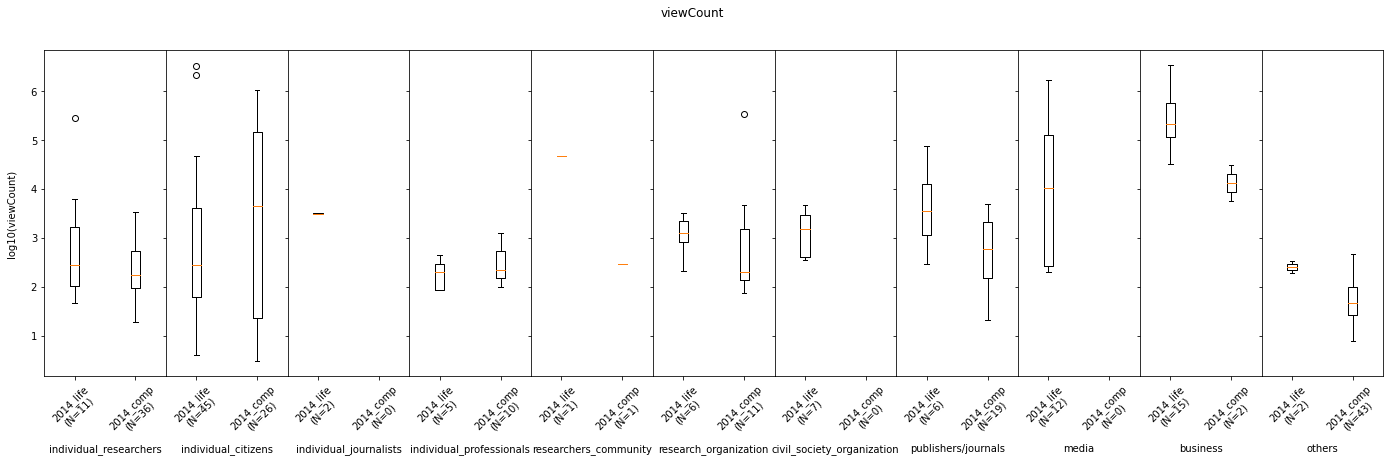

In [87]:
boxplot_by_label(targets=["2014_life", "2014_comp"], metric="viewCount", q=0.1, log_scale=True)